# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. I have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [23]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [24]:
df.shape

(294478, 5)

In [25]:
df.user_id.nunique()

290584

In [26]:
df.converted.mean()

0.11965919355605512

In [27]:
#treatment in group will be called A and new_page in landing_page will 
#be called B

t_not_n = df.query('group == "treatment" and landing_page != "new_page"')
len(t_not_n)
n_not_t = df.query('group != "treatment" and landing_page == "new_page"')

#calculate thenumber of time new_page and treatment don't line up
len(t_not_n) + len(n_not_t),len(t_not_n)


(3893, 1965)

 Do any of the rows have missing values?

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [29]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df1 = df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)

df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [30]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

 How many unique **user_id**s are in **df2**?

In [31]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.  What is it?

In [32]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


 Display the rows for the duplicate **user_id**? 

In [33]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [34]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

# Check again if the row with a duplicate user_id is deleted or not
df2.drop(labels=2893,inplace=True)

In [35]:
df2.converted.mean()

0.11959708724499628

 Given that an individual was in the `control` group, what is the probability they converted?

In [36]:
control_m=df2.query('group=="control"')['converted'].mean()
control_m

0.1203863045004612

 Given that an individual was in the `treatment` group, what is the probability they converted?

In [37]:
treatment_m=df2.query('group=="treatment"')['converted'].mean()
treatment_m

0.11880806551510564

In [38]:
obs_diff=treatment_m-control_m
obs_diff
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

-0.0015782389853555567

 What is the probability that an individual received the new page?

In [39]:
len(df.query('landing_page=="new_page"'))/len(df['landing_page'])

0.5

Note:there is not sufficient evidence to say that the new treatment page leads to more conversions.
12.03% that received the old_page were converted. 11.88% that received the new_page were converted. at the end, the new_page did not increase the conversion rate.

<a id='ab_test'></a>
## Part II - A/B Test



Note:Null hypothesis: the conversion rate of the old_page is greater or the same than the conversion rate of the newpage.$p{old}$ >= $p_{new}$
Alternative hypothesis: the conversion rate of the old_page is less than the conversion rate of the newpage $p{old}$ < $p_{new}$

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [64]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [65]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [66]:
n_new = len(df2.query('group == "treatment"'))

n_new


145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [67]:
n_old = len(df2.query('group == "control"'))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [97]:
# Simulate a Sample for the treatment Group
new_page=np.random.choice(2, size=n_new ,p=[p_new,(1 - p_new)]).mean()
new_page


0.88023535888789484

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [100]:
# Simulate a Sample for the control Group
old_page=np.random.choice(2, size=n_old ,p=[p_old,(1 - p_old)]).mean()
old_page


0.87988215372330902

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [101]:
new_page-old_page

0.00035320516458581253


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [102]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page=np.random.choice(2, size=n_new ,p=[p_new,(1 - p_new)]).mean()
    old_page=np.random.choice(2, size=n_old ,p=[p_old,(1 - p_old)]).mean()
    p_diffs.append(new_page-old_page)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



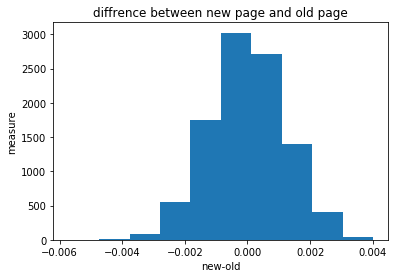

In [89]:
p_diffs=np.array(p_diffs)
plt.hist(p_diffs)
plt.xlabel('new-old')
plt.ylabel("measure")
plt.title("diffrence between new page and old page");

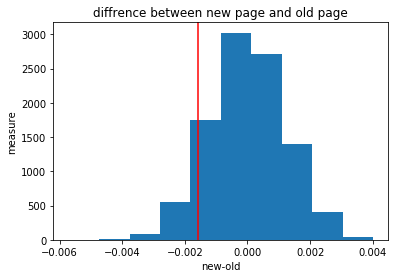

In [95]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('new-old')
plt.ylabel("measure")
plt.title("diffrence between new page and old page");

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [108]:
df_treat=df2.query('landing_page == "new_page"')["converted"].mean()
df_control=df2.query('landing_page == "old_page"')["converted"].mean()
obbs_diff=df_treat-df_control
obbs_diff

-0.0015782389853555567

In [109]:

(p_diffs>obbs_diff).mean()

0.90549999999999997

# Note
What I computed is the actual versus observed difference in means of converted old page and converted new page.
This means that we had random choices of these mean converted values for the observed difference, which is stored in p_diffs.
The actual difference was calculated from the dataset ab_data.csv. This value that we calculated, difference in means, is the p-value.
Our p-value is exceeds the critical value of 0.05 in this case and so we fail to reject the null hypothesis, we cannot assume the new page converts more users than the old page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
I could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [111]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('landing_page=="old_page" and converted==1'))

# number of conversions with the new_page
convert_new =len(df2.query('landing_page=="new_page" and converted==1'))

# number of individuals who were shown the old_page
n_old = len(df2.query('landing_page=="old_page"'))

# number of individuals who received new_page
n_new = len(df2.query('landing_page=="new_page"'))


In [113]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)
print(z_score, p_value)

1.31092419842 0.905058312759


 What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>



# Note
The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page

<a id='regression'></a>
### Part III - A regression approach



Note:we will use logistic regression.

In [41]:
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis = 1)

df2.head()

,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


Use **statsmodels** to instantiate regression model on the two columns i created in part (b)

In [42]:
df3=df2.rename(columns={'treatment':'ab_page'})
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


In [55]:
from scipy import stats
stats.chisqprob = lambda chisq, df3: stats.chi2.sf(chisq, df3)
df3['intercept']=1
lm=sm.Logit(df3['converted'],df3[['intercept','ab_page']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 21 Nov 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:25:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>** The answer.The p-value is very different. In part II the p-value is 0.18. This might be because the tests of the regression model (not the A/B test) assumes an intercept and because of differences in one or two-tailed testing.

 Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>It is a good idea to consider other factors in order to identify other potencial influences on the conversion rate.

In [56]:
# Read the countries.csv
countries_df=pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df3.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [ ]:
# Join with the df2 dataframe

In [57]:
# Create the necessary dummy variables
df_new[['CA','UK', 'US']]= pd.get_dummies(df_new['country'])

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [58]:
df_new.groupby(['country','ab_page'], as_index=False).mean()


,country,ab_page,converted,intercept,CA,UK,US
0,CA,0,0.118783,1.0,1,0,0
1,CA,1,0.111902,1.0,1,0,0
2,UK,0,0.120022,1.0,0,1,0
3,UK,1,0.121171,1.0,0,1,0
4,US,0,0.120630,1.0,0,0,1
5,US,1,0.118466,1.0,0,0,1


In [59]:
df_new['US_ab_page'] = df_new["US"] *df_new["ab_page"]
df_new['CA_ab_page'] = df_new["CA"] *df_new["ab_page"]

df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,US_ab_page,CA_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [62]:
# Fit your model, and summarize the results
df_new['intercept']=1
lm=sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','US',"US_ab_page","CA_ab_page"]])
results=lm.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 21 Nov 2021   Pseudo R-squ.:               3.482e-05
Time:                        15:28:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
US_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

>**conclusion .**
The p_value for both interaction terms is higher than 0.05.

Thus, the influence of landing_page in the US is not different to the influence of landing_page in the other countries.

And the influence of landing_page in Canada is not different to the influence of landing_page in the other countries.



based on statistical tests we made the result showed that the new page and old page have an equal chance of converting users, so we didn't need to create a new page
